<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# DSI-SG Project 2: Predicting the resale price of HDB housing

---
## Background
---

The Housing & Development Board (HDB) (Malay: Lembaga Perumahan dan Pembangunan; Chinese: 建屋发展局; Tamil: வீடமைப்பு வளர்ச்சிக் கழகம்) or often referred to as the Housing Board, is a statutory board under the Ministry of National Development responsible for Singapore's public housing. Founded in 1960 as a result of efforts in the late 1950s to set up an authority to take over the Singapore Improvement Trust's (SIT) public housing responsibilities, the HDB focused on the construction of emergency housing and the resettlement of kampong residents into public housing in the first few years of its existence.

The resale market in Singapore in recent years has known to be more competitive due to the lack of housing and with more citizen being weathier. There are many factors involving the resale prices. By using past sales data and building of a model, we are able to predict the HDB resale prices. 

We will be using a training set provided to train our model before using the test set to test our model. The main feature that we are looking out for is the 'resale prices' feature. 


----
## Problem Statement
----

I'm a Business analyst that was commissioned by the Housing Board Authority (HDB) to help analyze and predict the current trend of resale prices from 2012 - 2021. 

As there are many factors involving the prediction of HDB resale prices, this include the flat type, town area, flat model, floor area. It is necessary to develop a model to help predict the resale price based on the mentioned factors.

The datasets used are listed below to help develop our model. The evaluation metric for the model used will be the Root Mean Square Error (RMSE) which measures the difference between the predicted and actual prices. The lower the RMSE,it indicate better accuracy of the model. 

---
##  Dataset
---
There are 3 datasets included in the [`data`](./data/) folder for this project.

* [`train.csv`](./datasets/train.csv): This data contains all of the training data for model.
The target variable (SalePrice) is removed from the test set
* [`test.csv`](./datasets/test.csv): This data contains the test data for your model. You will feed this data into your regression model to make predictions.
* [`sample_sub_reg.csv`](./datasets/sample_sub_reg.csv): An example of a correctly formatted submission for this challenge (with a random number provided as predictions for SalePrice. Please ensure that your submission to Kaggle matches this format.


---
## Import of Libraries  / Data
---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#sklearn package
from sklearn.model_selection import train_test_split,cross_val_score, cross_val_predict
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression

In [3]:
df = pd.read_csv('./datasets/train.csv')
df_test = pd.read_csv('./datasets/test.csv')
print(df.shape)
print(df_test.shape)

(150634, 78)
(16737, 77)


/var/folders/rg/j9sphkcn70nbb5wrnyxnprk80000gn/T/ipykernel_58436/2632201934.py:1: DtypeWarning: Columns (42) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('./datasets/train.csv')
/var/folders/rg/j9sphkcn70nbb5wrnyxnprk80000gn/T/ipykernel_58436/2632201934.py:2: DtypeWarning: Columns (41) have mixed types. Specify dtype option on import or set low_memory=False.
  df_test = pd.read_csv('./datasets/test.csv')


There are 78 columns (features) in the training set whrere there is only 77 columns (features) in the test set.

## Data Cleaning

##### Sorting and Renaming of Columns (Training Set)

In [4]:
#Rename for Training set
df.rename(columns = {'Tranc_YearMonth' : 'yyyy-mmm'}, inplace= True)
#Rename for Test set
df_test.rename(columns = {'Tranc_YearMonth' : 'yyyy-mmm'}, inplace= True)

#Rename for Training set
df.columns = df.columns.str.lower().str.replace(' ','_')
#Rename for Test set
df_test.columns = df_test.columns.str.lower().str.replace(' ','_')


##### Dataset information

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150634 entries, 0 to 150633
Data columns (total 78 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   id                         150634 non-null  int64  
 1   yyyy-mmm                   150634 non-null  object 
 2   town                       150634 non-null  object 
 3   flat_type                  150634 non-null  object 
 4   block                      150634 non-null  object 
 5   street_name                150634 non-null  object 
 6   storey_range               150634 non-null  object 
 7   floor_area_sqm             150634 non-null  float64
 8   flat_model                 150634 non-null  object 
 9   lease_commence_date        150634 non-null  int64  
 10  resale_price               150634 non-null  float64
 11  tranc_year                 150634 non-null  int64  
 12  tranc_month                150634 non-null  int64  
 13  mid_storey                 15

In [6]:
#Statistical Table

df.describe()

,id,floor_area_sqm,lease_commence_date,resale_price,tranc_year,tranc_month,mid_storey,lower,upper,mid,...,pri_sch_nearest_distance,vacancy,pri_sch_affiliation,pri_sch_latitude,pri_sch_longitude,sec_sch_nearest_dist,cutoff_point,affiliation,sec_sch_latitude,sec_sch_longitude
count,150634.000000,150634.00000,150634.000000,1.506340e+05,150634.000000,150634.000000,150634.000000,150634.000000,150634.000000,150634.000000,...,150634.000000,150634.000000,150634.000000,150634.000000,150634.000000,150634.000000,150634.000000,150634.000000,150634.000000,150634.000000
mean,93047.887496,97.19763,1992.448464,4.491615e+05,2016.489551,6.580500,8.284823,7.248370,9.321275,8.284823,...,395.172974,55.368190,0.113195,1.366268,103.839106,508.533220,210.146428,0.031879,1.365986,103.839340
std,53679.906247,24.40304,12.138829,1.433076e+05,2.752396,3.345468,5.508074,5.515155,5.507364,5.508074,...,234.760931,17.903918,0.316832,0.042669,0.072637,309.066265,20.010489,0.175677,0.042599,0.072630
min,1.000000,31.00000,1966.000000,1.500000e+05,2012.000000,1.000000,2.000000,1.000000,3.000000,2.000000,...,45.668324,20.000000,0.000000,1.274962,103.687724,38.913475,188.000000,0.000000,1.276029,103.687207
25%,46469.250000,75.00000,1984.000000,3.470000e+05,2014.000000,4.000000,5.000000,4.000000,6.000000,5.000000,...,227.083163,44.000000,0.000000,1.337289,103.773754,290.285883,188.000000,0.000000,1.337545,103.776008
50%,93077.500000,95.00000,1992.000000,4.200000e+05,2017.000000,7.000000,8.000000,7.000000,9.000000,8.000000,...,348.876691,54.000000,0.000000,1.364639,103.844210,447.377670,208.000000,0.000000,1.366132,103.842719
75%,139574.750000,112.00000,2001.000000,5.200000e+05,2019.000000,9.000000,11.000000,10.000000,12.000000,11.000000,...,502.179385,67.000000,0.000000,1.393910,103.898773,644.284099,224.000000,0.000000,1.391781,103.899872
max,185966.000000,280.00000,2019.000000,1.258000e+06,2021.000000,12.000000,50.000000,49.000000,51.000000,50.000000,...,3305.841039,110.000000,1.000000,1.456667,103.962919,3638.977233,260.000000,1.000000,1.453280,103.961105


## Data Cleaning

#### Checking and cleaning of Null Value for Training Set

In [7]:
df.isnull().sum().sum()

308444

There is a total of 308444 missing values

In [8]:
df.isnull().sum().sort_values(ascending=False)[:10]

hawker_within_500m         97390
mall_within_500m           92789
hawker_within_1km          60868
hawker_within_2km          29202
mall_within_1km            25426
mall_within_2km             1940
mall_nearest_distance        829
hawker_nearest_distance        0
mrt_nearest_distance           0
hawker_market_stalls           0
dtype: int64

In [9]:
#To fillna all the missing values with "0"
df.fillna(0,inplace=True)
df.isnull().sum().sort_values(ascending=False)[:10]

id                         0
mall_within_2km            0
mrt_nearest_distance       0
hawker_market_stalls       0
hawker_food_stalls         0
hawker_within_2km          0
hawker_within_1km          0
hawker_within_500m         0
hawker_nearest_distance    0
mall_within_1km            0
dtype: int64

#### Checking and cleaning of Null Value for Test Set

In [10]:
df_test.isnull().sum().sum()

34113

In [11]:
df_test.isnull().sum().sort_values(ascending=False)[:10]

hawker_within_500m       10755
mall_within_500m         10292
hawker_within_1km         6729
hawker_within_2km         3254
mall_within_1km           2786
mall_within_2km            213
mall_nearest_distance       84
mrt_name                     0
mrt_nearest_distance         0
hawker_market_stalls         0
dtype: int64

In [12]:
#To fillna all the missing values with "0"
df_test.fillna(0,inplace=True)
df_test.isnull().sum().sort_values(ascending=False)[:10]

id                         0
hawker_nearest_distance    0
mrt_name                   0
mrt_nearest_distance       0
hawker_market_stalls       0
hawker_food_stalls         0
hawker_within_2km          0
hawker_within_1km          0
hawker_within_500m         0
mall_within_2km            0
dtype: int64

#### Checking for Duplication for Training Set

In [13]:
df.duplicated().sum()

0

#### Checking for Duplication for Test Set

In [14]:
df_test.duplicated().sum()

0

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150634 entries, 0 to 150633
Data columns (total 78 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   id                         150634 non-null  int64  
 1   yyyy-mmm                   150634 non-null  object 
 2   town                       150634 non-null  object 
 3   flat_type                  150634 non-null  object 
 4   block                      150634 non-null  object 
 5   street_name                150634 non-null  object 
 6   storey_range               150634 non-null  object 
 7   floor_area_sqm             150634 non-null  float64
 8   flat_model                 150634 non-null  object 
 9   lease_commence_date        150634 non-null  int64  
 10  resale_price               150634 non-null  float64
 11  tranc_year                 150634 non-null  int64  
 12  tranc_month                150634 non-null  int64  
 13  mid_storey                 15

#### Removing of columns for Training Set

To drop some of the features that it has too many uniques values and self-repeating which might cause problems in the modelling.

Features to be dropped:

 1. "Block","street name","address","Postal",'bus_stop_name' : These have multi-dtypes which might cause problems
 
 2. 'Residental", "Commerical": A boolean value which doesn't give much information

 3. 'full_flat_type': There is already a model and type in the dataframe.

 4. 'mid_storey': There is a feature consisting of mid. 

 5. 'yyyy-mmm': Combination of tranc_year and tranc_month
 
 6. 'town': It is the same value as planning area

In [16]:
drop_train_set = ['residential','commercial','market_hawker','price_per_sqft','floor_area_sqm',
                 'block','street_name','address','postal','bus_stop_name','full_flat_type','mid_storey',
                 'total_dwelling_units']

df.drop(columns = drop_train_set,inplace = True)

In [17]:
df.shape

(150634, 65)

#### Removing of columns for Test Set

In [18]:
drop_test_set = ['residential','commercial','market_hawker','price_per_sqft','floor_area_sqm',
                 'block','street_name','address','postal','bus_stop_name','full_flat_type','mid_storey',
                  'total_dwelling_units']

df_test.drop(columns = drop_test_set,inplace = True)

In [19]:
df_test.shape

(16737, 64)

## Data Dictionary

|Feature|Type|Dataset|Description|
|---|---|---|---|
id|int64||N/A  
town|object||HDB township where the flat is located, e.g. BUKIT MERAH
flat_type|object||type of the resale flat unit, e.g. 3 ROOM
storey_range|object||storey_range
flat_model |object||HDB model of the resale flat, e.g. Multi Generation
lease_commence_date |int64||commencement year of the flat unit's 99-year lease
resale_price|float64||This is the target variable for the modelling
tranc_year|int64||year of resale transaction
tranc_month|int64||month of resale transaction
lower|int64||lower value of storey_range
upper|int64||upper value of storey_range
mid|int64||middle value of storey_range
floor_area_sqft|float64||floor area of the resale flat unit in square feet
hdb_age|int64||number of years from lease_commence_date to present year
max_floor_lvl|int64||highest floor of the resale flat
year_completed|int64||year which construction was completed for resale flat
multistorey_carpark|object||boolean value if resale flat has a multistorey carpark in the same block
precinct_pavilion|object||boolean value if resale flat has a pavilion in the same block
1room_sold|int64||number of 1-room residential units in the resale flat
2room_sold|int64||number of 2-room residential units in the resale flat              
3room_sold|int64||number of 3-room residential units in the resale flat
4room_sold|int64||number of 4-room residential units in the resale flat
5room_sold|int64||number of 5-room residential units in the resale flat
exec_sold|int64||number of executive type residential units in the resale flat block               
multigen_sold|int64||number of multi-generational type residential units in the resale flat block
studio_apartment_sold|int64||number of studio apartment type residential units in the resale flat block 
1room_rental|int64||number of 1-room rental residential units in the resale flat block
2room_rental|int64||number of 2-room rental residential units in the resale flat block    
3room_rental|int64||number of 3-room rental residential units in the resale flat block
other_room_rental|int64||number of "other" type rental residential units in the resale flat block 
latitude|float64||Latitude based on postal code
longitude|float64||Longitude based on postal code
mall_nearest_distance|int64||distance (in metres) to the nearest mall
mall_within_500m|int64||number of mall within 500 metres
mall_within_1km|int64||number of mall within 1 kilometre
mall_within_2km|int64||number of mall within 2 kilometres
hawker_nearest_distance|int64||number of hawker food stalls in the nearest hawker centre
hawker_within_500m|int64||number of hawker centres within 500 metres
hawker_within_1km|int64||number of hawker centres within 1 kilometre
hawker_within_2km|int64||number of hawker centres within 2 kilometres
hawker_food_stalls|int64||number of hawker food stalls in the nearest hawker centre
hawker_market_stalls|int64||number of hawker and market stalls in the nearest hawker centre 
mrt_nearest_distance|int64||distance (in metres) to the nearest MRT station
mrt_name|object||name of the nearest MRT station
bus_interchange|int64||boolean value if the nearest MRT station is also a bus interchange
mrt_interchange|int64||boolean value if the nearest MRT station is a train interchange station
mrt_latitude|float64||latitude (in decimal degrees) of the the nearest MRT station
mrt_longitude|float64||longitude (in decimal degrees) of the nearest MRT station
bus_stop_nearest_distance|int64||distance (in metres) to the nearest bus stop
bus_stop_latitude|float64||latitude (in decimal degrees) of the the nearest bus stop
bus_stop_longitude|float64||longitude (in decimal degrees) of the nearest bus stop
pri_sch_nearest_distance|int64||distance (in metres) to the nearest primary school
pri_sch_name|object||name of the nearest primary school
vacancy|int64||number of vacancies in the nearest primary school
pri_sch_affiliation|int64||boolean value if the nearest primary school has a secondary school affiliation
pri_sch_latitude|float64||latitude (in decimal degrees) of the the nearest primary school
pri_sch_longitude|float||longitude (in decimal degrees) of the nearest primary school
sec_sch_nearest_dist|int64||distance (in metres) to the nearest secondary school
sec_sch_name|object||name of the nearest secondary school
cutoff_point|int64||PSLE cutoff point of the nearest secondary school
affiliation|int64||boolean value if the nearest secondary school has an primary school affiliation
sec_sch_latitude|float64||latitude (in decimal degrees) of the the nearest secondary school
sec_sch_longitude|float64||longitude (in decimal degrees) of the nearest secondary school


# Exploratory Data Analysis

#### Using Heatmap to see correlationship

In [20]:
corr = round(df.corrwith(df["resale_price"]).sort_values(ascending=False),3).drop(["id"])
df_corr = pd.DataFrame(corr)

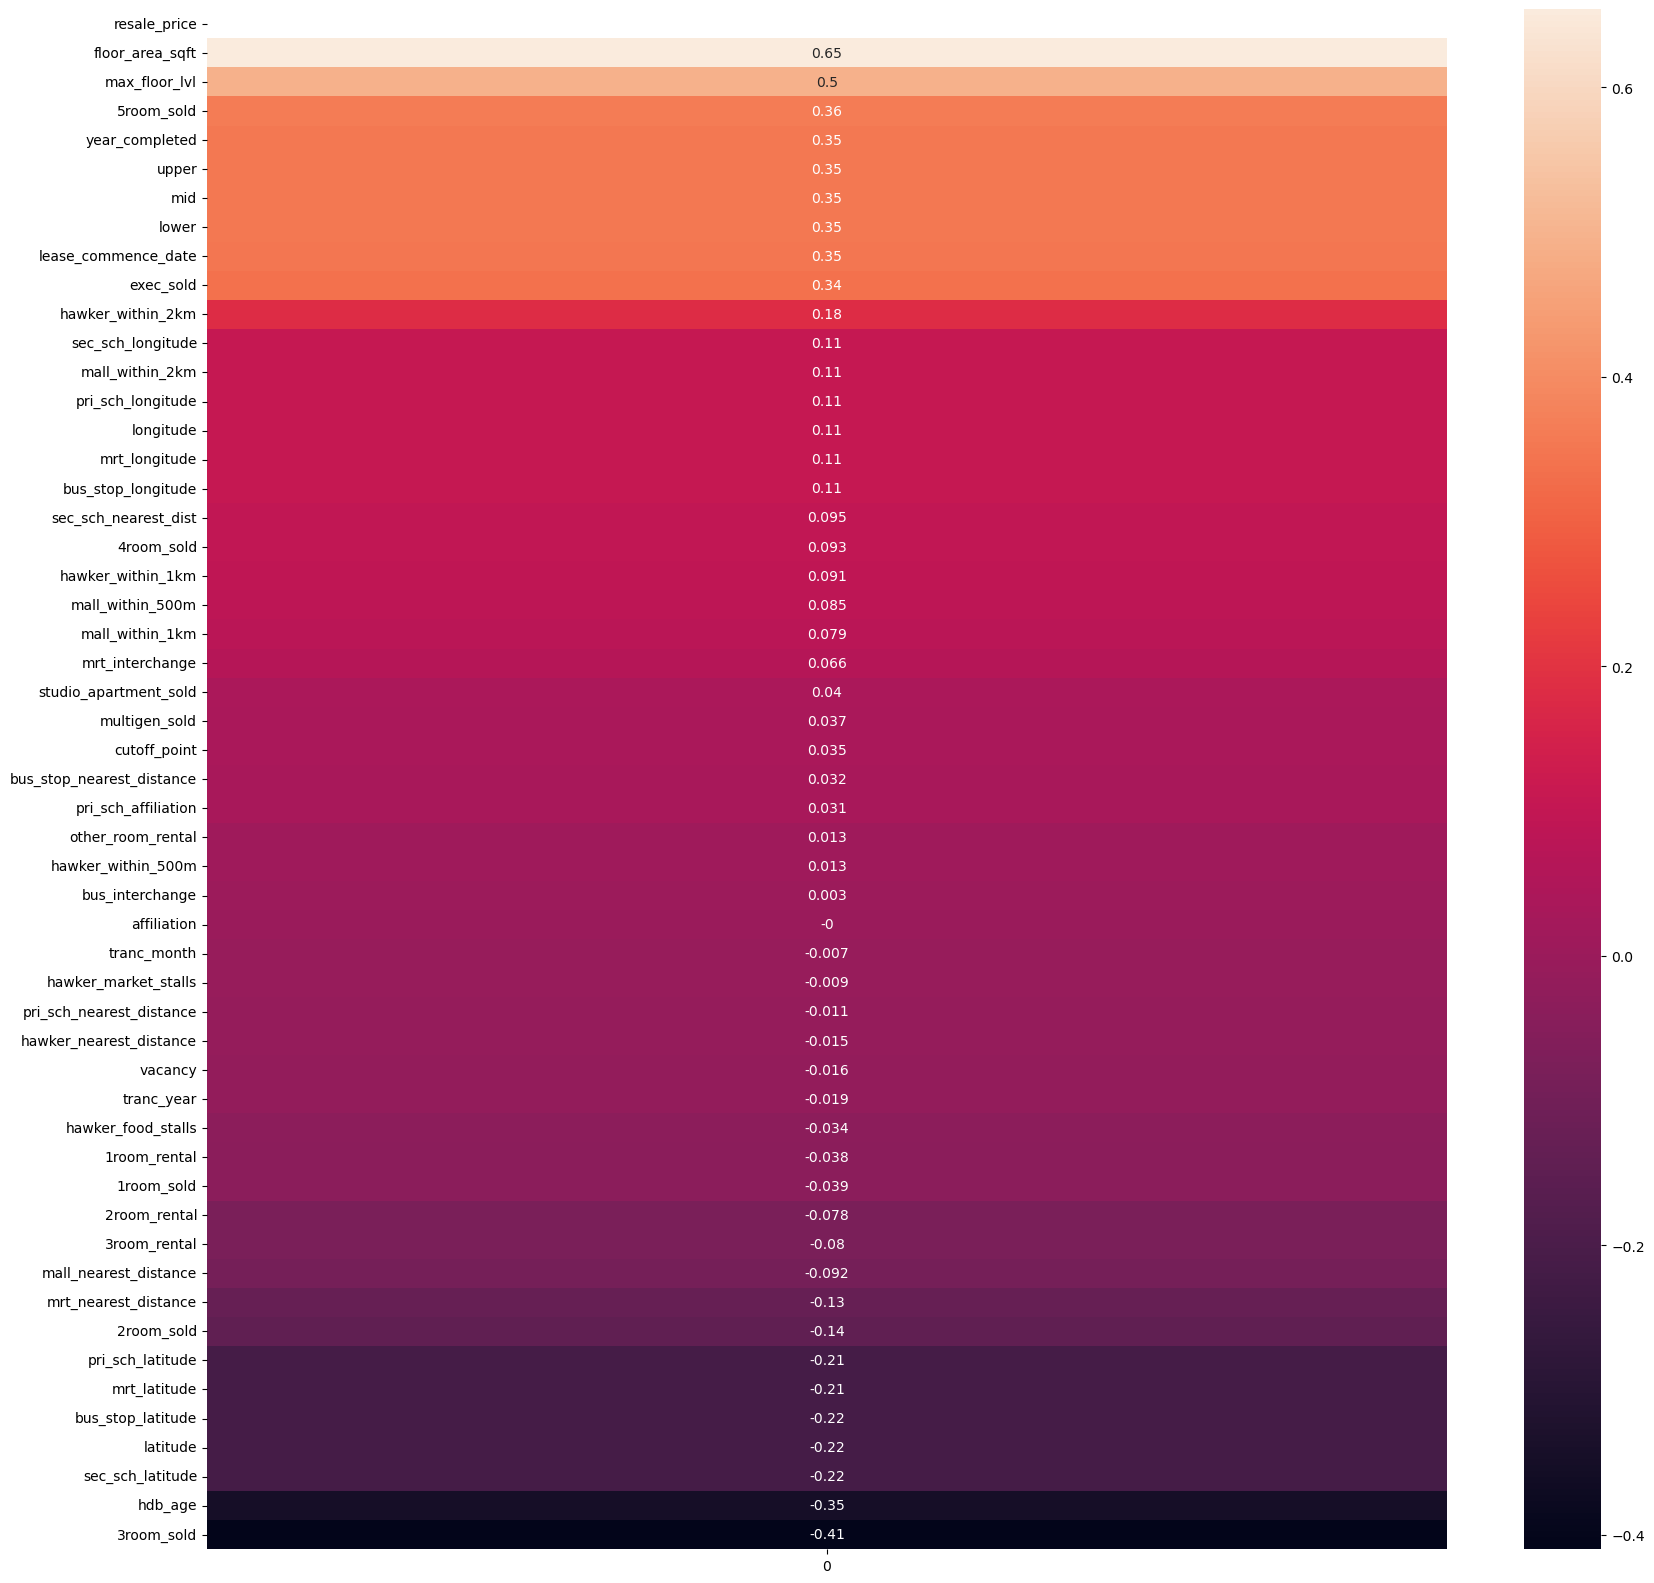

In [21]:
plt.figure(figsize=(20,20))
mask = np.triu(np.ones_like(df_corr, dtype ='bool'))
sns.heatmap(df_corr, annot=True, mask = mask);

#### Using of Boxplot for 2020

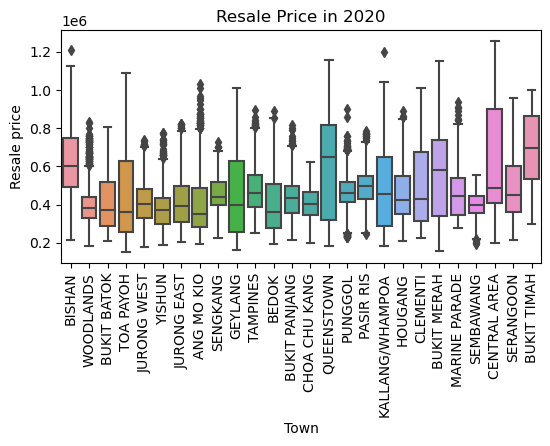

In [22]:
plt.figure(figsize=(15,9),constrained_layout=True)


plt.subplot(3, 3, 2)
sns.boxplot(data=df.loc[df['tranc_year'] == 2020], x= "town", y="resale_price")
plt.title("Resale Price in 2020")
plt.xlabel('Town')
plt.ylabel('Resale price')
plt.xticks(rotation = 90);

Based on the above graph, we can conclude that central area resale price is considered to be the most expensive as it is in the prime area of Singapore. It is followed by bukit timah where most of the private housing are located.

#### Using of reg-plot to see the correlation

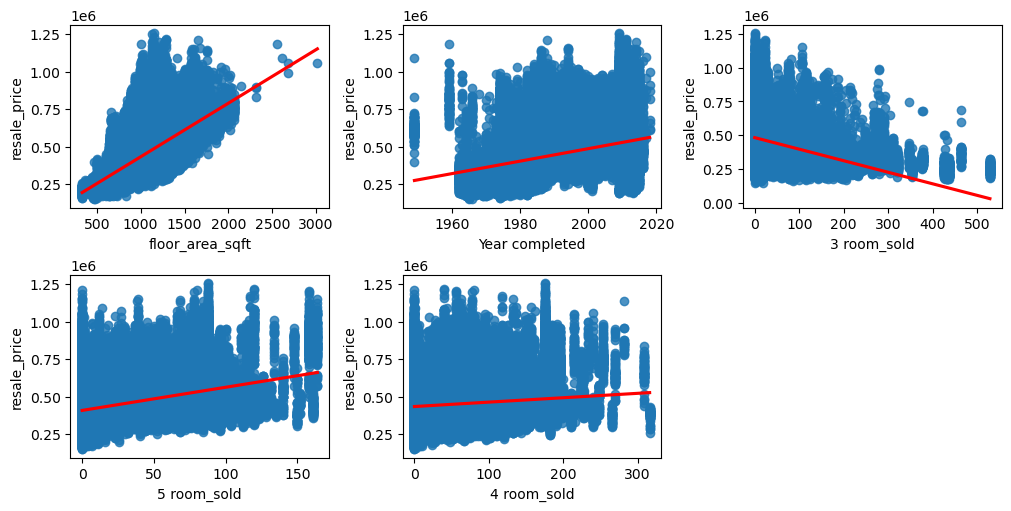

In [23]:
plt.figure(figsize=(10,5),constrained_layout=True)
plt.subplot(2,3,1)
sns.regplot(data = df, x = "floor_area_sqft", y = "resale_price", line_kws={"color": "red"})
plt.xlabel('floor_area_sqft')
plt.ylabel('resale_price')


plt.subplot(2,3,2)
sns.regplot(data = df, x = "year_completed", y = "resale_price",line_kws={"color": "red"})
plt.xlabel('Year completed')
plt.ylabel('resale_price')


plt.subplot(2,3,3)
sns.regplot(data = df, x = "3room_sold", y = "resale_price",line_kws={"color": "red"})
plt.xlabel('3 room_sold')
plt.ylabel('resale_price')


plt.subplot(2,3,4)
sns.regplot(data = df, x = "5room_sold", y = "resale_price",line_kws={"color": "red"})
plt.xlabel('5 room_sold')
plt.ylabel('resale_price')


plt.subplot(2,3,5)
sns.regplot(data = df, x = "4room_sold", y = "resale_price",line_kws={"color": "red"})
plt.xlabel('4 room_sold')
plt.ylabel('resale_price');


Based on the reg plot above, there seems not to have much correlationship with resale price except for floor_area_sqft. This is naturally so as real estate prices are based on floor_area. 

#### Using of bar chart for Year 2021

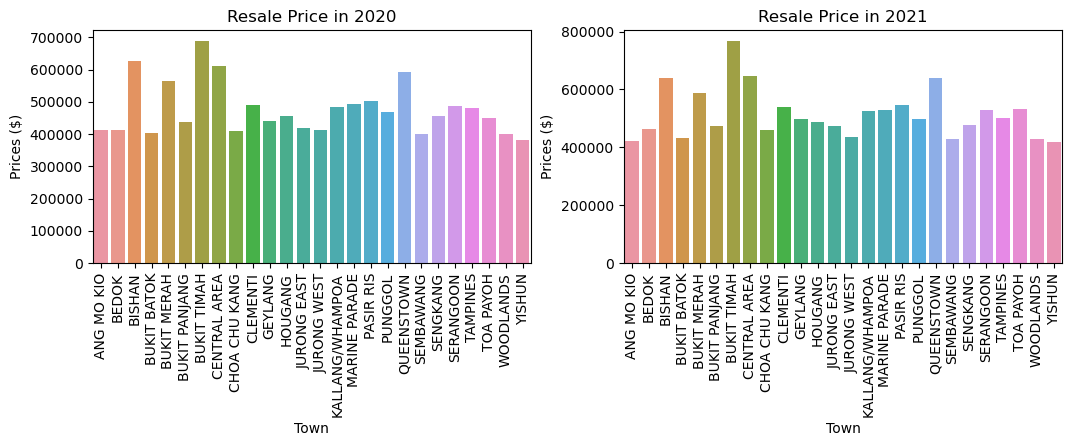

In [24]:
plt.figure(figsize=(15,9),constrained_layout=True)

plt.subplot(3, 3, 1)
df_resale_2020 = df[df['tranc_year']==2020].groupby('town')['resale_price'].mean().reset_index()
sns.barplot(x = 'town', y = 'resale_price', data = df_resale_2020)
plt.title('Resale Price in 2020')
plt.xlabel('Town')
plt.ylabel('Prices ($)')
plt.xticks(rotation = 90);

plt.subplot(3, 3, 2)
df_resale_2021 = df[df['tranc_year']==2021].groupby('town')['resale_price'].mean().reset_index()
sns.barplot(x = 'town', y = 'resale_price', data = df_resale_2021)
plt.title('Resale Price in 2021')
plt.xlabel('Town')
plt.ylabel('Prices ($)')
plt.xticks(rotation = 90);

Based on the above graph, there is a trend on the increase of resale prices throughout the different towns in singapore. The highest increase is in fact bukit timah. The first reason behind rising property prices in the last two years, is that central banks have reduced interest rates in a bid to stimulate the economy and prevent an economic recession during a drawn-out pandemic.

#### Barchart to see the number of transaction per year

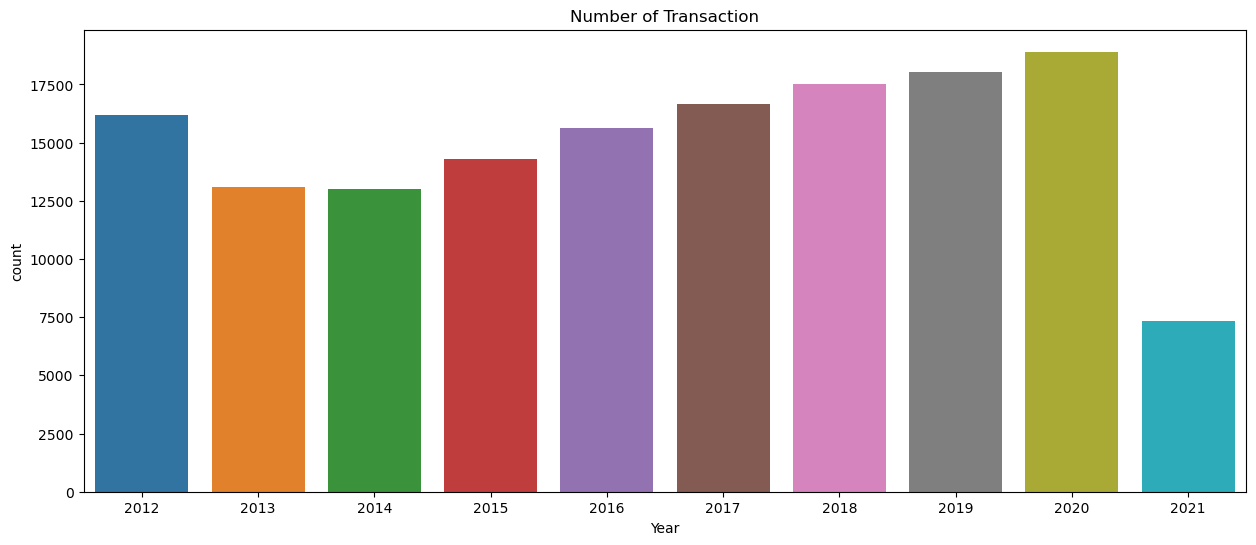

In [25]:
fig = plt.figure()
fig.set_size_inches(15, 6)
sns.countplot(data = df, x = "tranc_year")
plt.title('Number of Transaction')
plt.xlabel('Year');

Based on the number of transaction, there is increase of activities from 2013 to 2020. However, there is a massive dip in 2021. This was due to covid-19 where foreigners usually have rental have all move back to their home countries. Another possible reason was as the world or Singapore have yet to know what is happening in the future, people are holding back on purchasing homes. 

#### Kde plot to see the density of the different types of room being in transaction

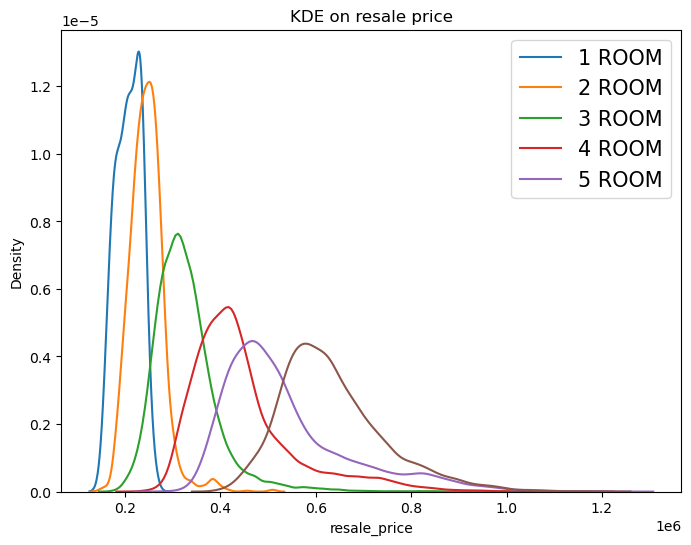

In [26]:
fig = plt.figure()
fig.set_size_inches(8, 6)

sns.kdeplot(df[df['flat_type'] == '1 ROOM']['resale_price']);
sns.kdeplot(df[df['flat_type'] == '2 ROOM']['resale_price']);
sns.kdeplot(df[df['flat_type'] == '3 ROOM']['resale_price']);
sns.kdeplot(df[df['flat_type'] == '4 ROOM']['resale_price']);
sns.kdeplot(df[df['flat_type'] == '5 ROOM']['resale_price']);
sns.kdeplot(df[df['flat_type'] == 'EXECUTIVE']['resale_price']);
sns.kdeplot(df[df['flat_type'] == 'MULTI GENERATION']['resale_price']);

plt.title("KDE on resale price")
plt.legend(loc='upper right', labels=['1 ROOM','2 ROOM', '3 ROOM', '4 ROOM', '5 ROOM'], prop={'size': 15});



Based on the above KDE model, we can assume that there is a high demand of 1-room and 2-room flats. 

#### Map of Singapore with area of high resale prices

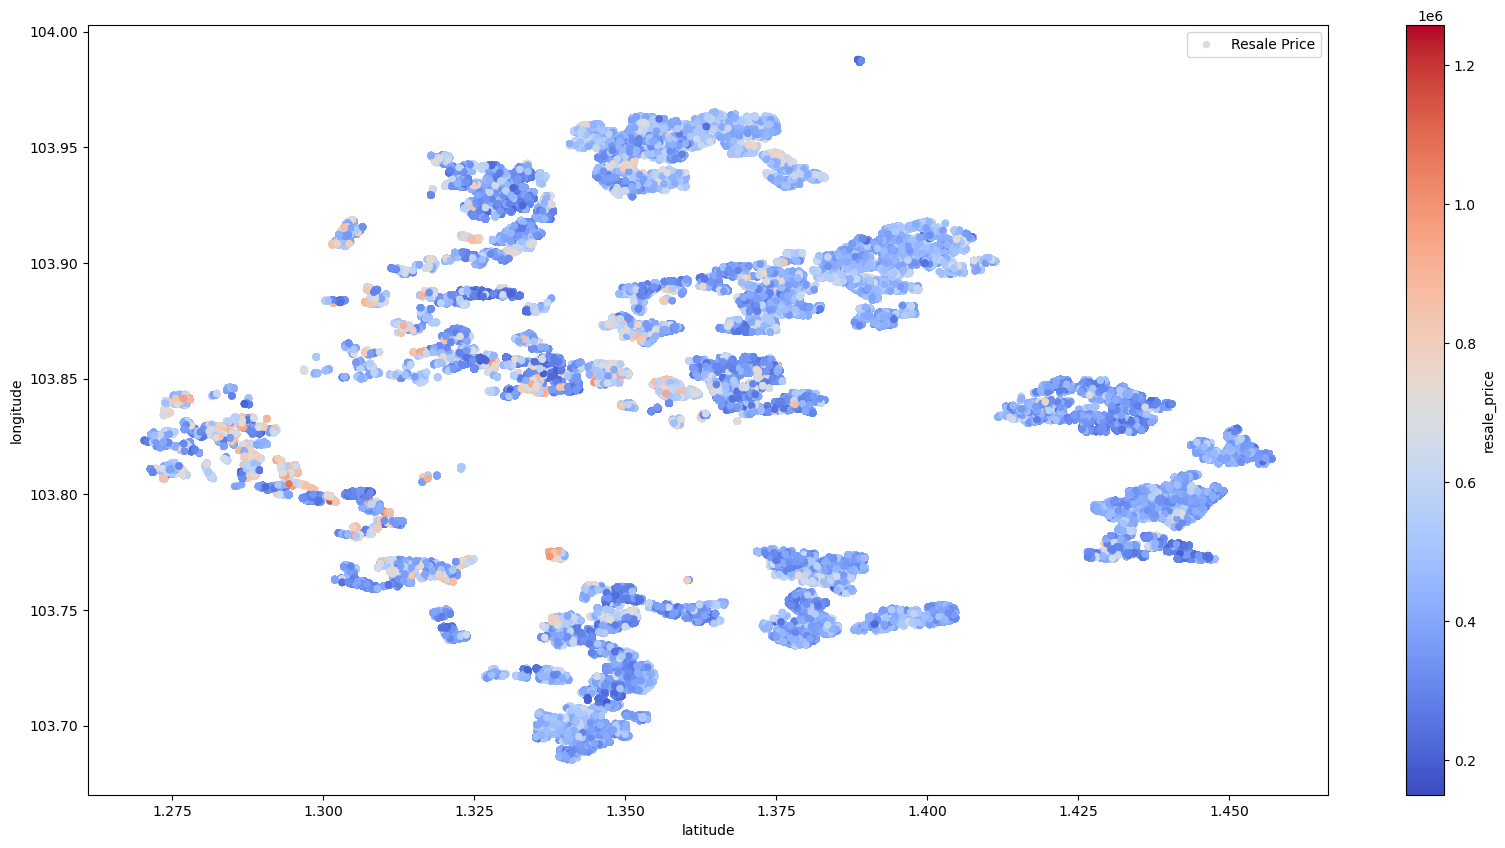

In [27]:
df.plot(kind='scatter', 
                x = 'latitude', 
                y= 'longitude', 
                c ='resale_price', 
                label= 'Resale Price', 
                cmap = 'coolwarm',
                colorbar = True,
                figsize = (20,10))
plt.show()

There seems to have a trend that the resale prices are the highest in the west and northern part of singapore. This was also due to the high price/sqft that may have contribute to higher resale price.

#### Mrt name in relationship with resale price

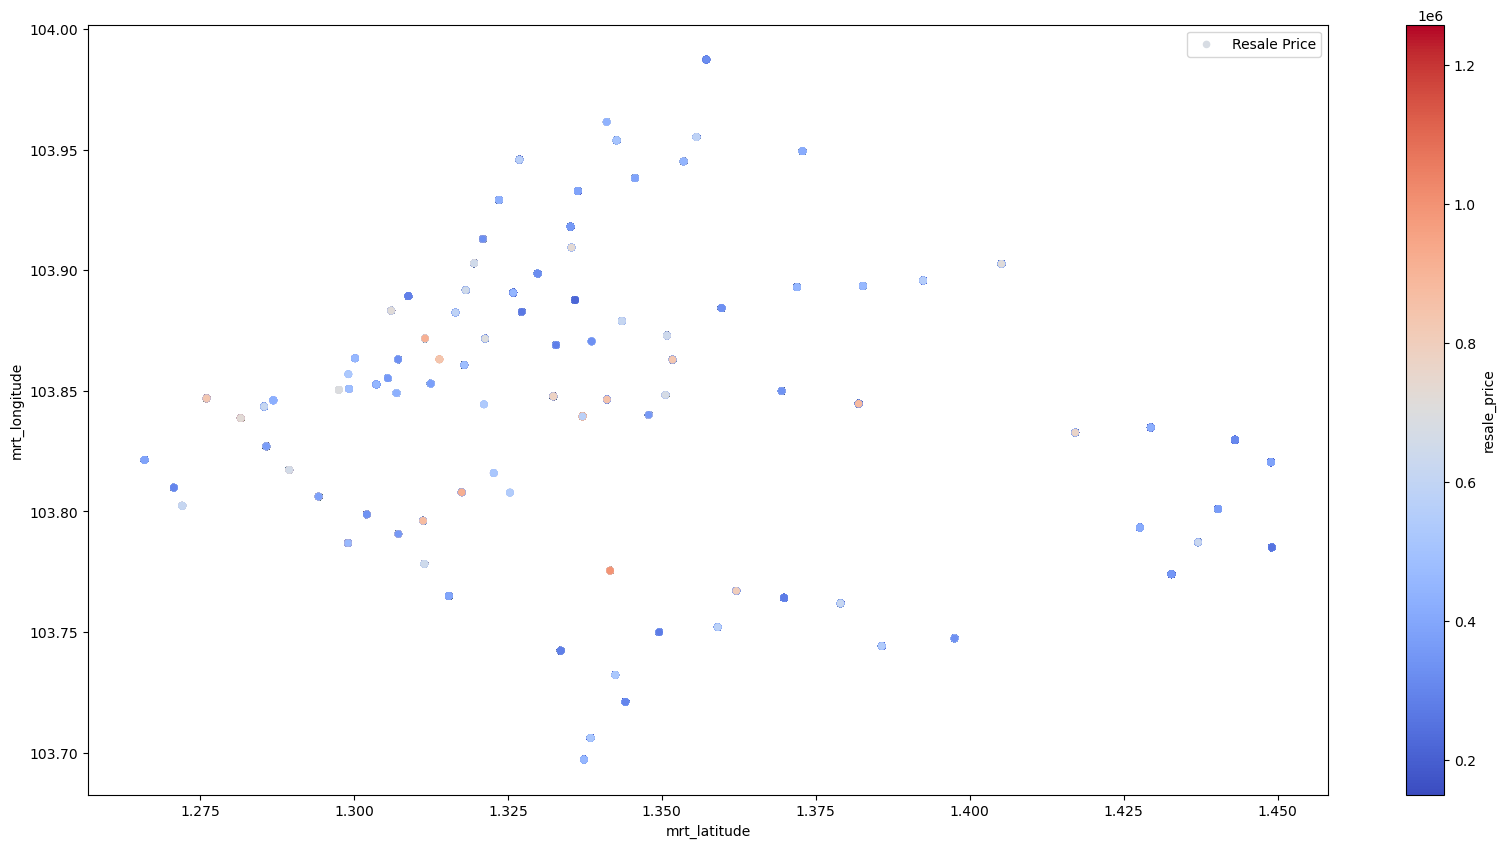

In [28]:
df.plot(kind='scatter', 
                x = 'mrt_latitude', 
                y= 'mrt_longitude', 
                c ='resale_price', 
                label= 'Resale Price', 
                cmap = 'coolwarm',
                colorbar = True,
                figsize = (20,10))

plt.show()

Based on the above scatterplot, I wanted to see if there is any relationship between resale prices and area in the mrt. We can see that there are not many points available, however, we can see that the central area and certain west side, the price are pretty high.

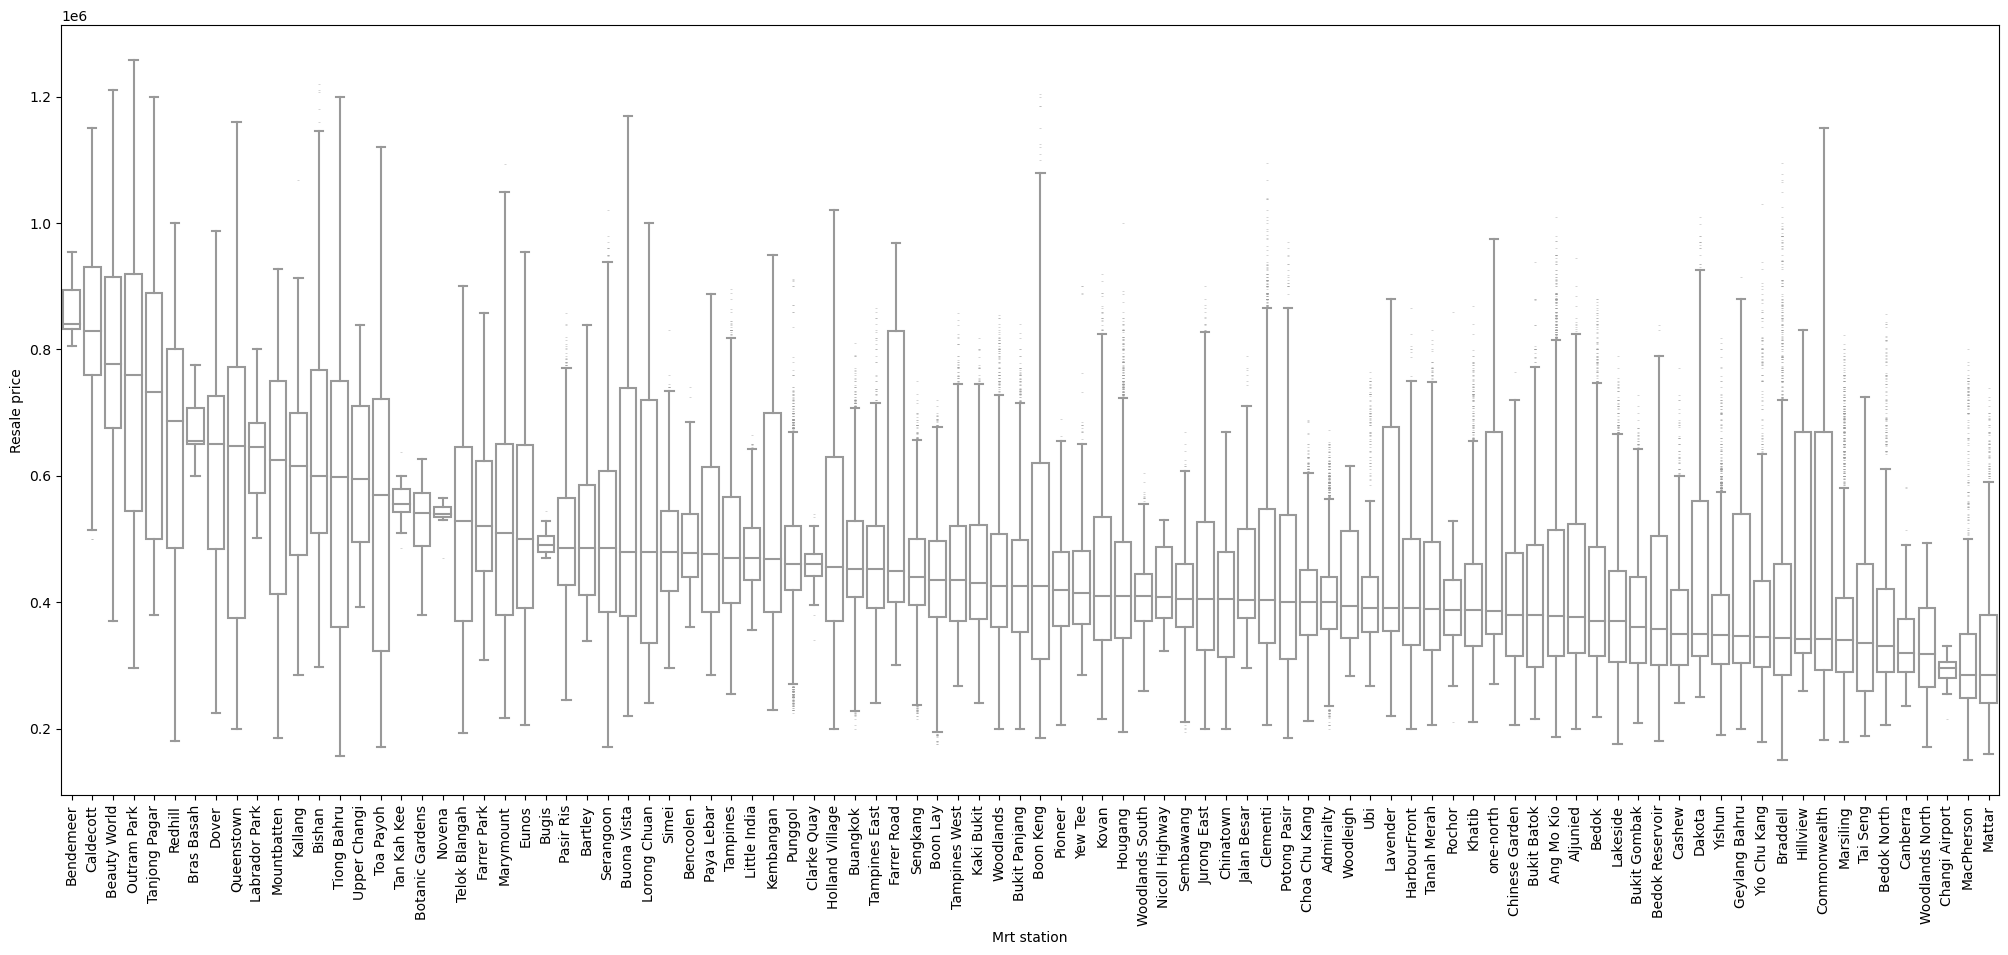

In [29]:
plt.figure(figsize=(25,10))
mrt_price = df.groupby("mrt_name")["resale_price"].median().sort_values(ascending= False).index
sns.boxplot(x="mrt_name", y="resale_price", data=df, fliersize=.1, color="white", order=mrt_price)


plt.xlabel('Mrt station')
plt.ylabel('Resale price')
           
plt.xticks(rotation = 90);
#chart.set_xticklabels(chart.get_xticklabels(), rotation=90);

There is a high correlationship where Caldecott command the highest resale price where matter is the lowest due to the area being not many people.

## Preprocessing

In [30]:
df.shape

(150634, 65)

In [31]:
print(df.shape)
print(df_test.shape)

(150634, 65)
(16737, 64)


##### Train Validation split

In [32]:
#drop town as we will be using planning_area for Training set 
df.drop(columns = ['town','id'],inplace= True)

#drop town in Test set
df_test.drop(columns = ['town','id'],inplace=True)


In [33]:
X = df.drop(columns =['resale_price'])
y = df['resale_price']

In [34]:
X_train , X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=111)

In [35]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(128038, 62) (128038,)
(22596, 62) (22596,)


#### Preprocessing for col transformer

In [36]:
cat_cols = X.select_dtypes(['object'])
new_cat_cols = list(cat_cols.columns)
new_cat_cols

['yyyy-mmm',
 'flat_type',
 'storey_range',
 'flat_model',
 'multistorey_carpark',
 'precinct_pavilion',
 'planning_area',
 'mrt_name',
 'pri_sch_name',
 'sec_sch_name']

In [37]:
num_cols = X.select_dtypes(['int64','float64'])
new_num_cols = list(num_cols.columns)
new_num_cols

['lease_commence_date',
 'tranc_year',
 'tranc_month',
 'lower',
 'upper',
 'mid',
 'floor_area_sqft',
 'hdb_age',
 'max_floor_lvl',
 'year_completed',
 '1room_sold',
 '2room_sold',
 '3room_sold',
 '4room_sold',
 '5room_sold',
 'exec_sold',
 'multigen_sold',
 'studio_apartment_sold',
 '1room_rental',
 '2room_rental',
 '3room_rental',
 'other_room_rental',
 'latitude',
 'longitude',
 'mall_nearest_distance',
 'mall_within_500m',
 'mall_within_1km',
 'mall_within_2km',
 'hawker_nearest_distance',
 'hawker_within_500m',
 'hawker_within_1km',
 'hawker_within_2km',
 'hawker_food_stalls',
 'hawker_market_stalls',
 'mrt_nearest_distance',
 'bus_interchange',
 'mrt_interchange',
 'mrt_latitude',
 'mrt_longitude',
 'bus_stop_nearest_distance',
 'bus_stop_latitude',
 'bus_stop_longitude',
 'pri_sch_nearest_distance',
 'vacancy',
 'pri_sch_affiliation',
 'pri_sch_latitude',
 'pri_sch_longitude',
 'sec_sch_nearest_dist',
 'cutoff_point',
 'affiliation',
 'sec_sch_latitude',
 'sec_sch_longitude']

#### Preprocessing: OneHotEncoder and Scaling

In [38]:
col_transformer = ColumnTransformer(transformers=[("numerical", StandardScaler(),new_num_cols), 
                                                  ("categoric",OneHotEncoder(handle_unknown = "ignore"),new_cat_cols)])

## Modelling

### Linear Regression

In [39]:
#Define a variable for Linear Regression
lr = LinearRegression()

In [40]:
#building a pipeline
steps=[
    ("ct", col_transformer),
    ('feat_sel', SelectKBest(k=30)),
    ("regression", lr)]

lr_pipeline = Pipeline(steps = steps)

In [41]:
#To fit the training set into the pipeline
lr_pipeline.fit(X_train,y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('numerical', StandardScaler(),
                                                  ['lease_commence_date',
                                                   'tranc_year', 'tranc_month',
                                                   'lower', 'upper', 'mid',
                                                   'floor_area_sqft', 'hdb_age',
                                                   'max_floor_lvl',
                                                   'year_completed',
                                                   '1room_sold', '2room_sold',
                                                   '3room_sold', '4room_sold',
                                                   '5room_sold', 'exec_sold',
                                                   'multigen_sold',
                                                   'studio_apartment_sold',
                                                   '1room_rental',
 

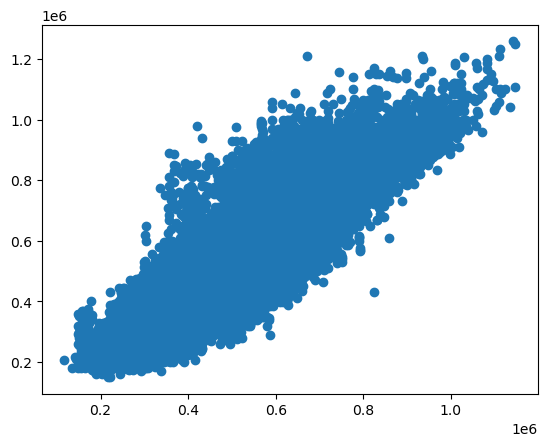

In [42]:
#Predicting y
lr_y_pred = lr_pipeline.predict(X_train)
plt.scatter(lr_y_pred,y_train);

##### R2 Score for Training set

In [43]:
#training
lr_pipeline.score(X_train,y_train)
print(f'R2 score(Training): {lr_pipeline.score(X_train,y_train)}')

#validation
lr_pipeline.score(X_val,y_val)
print(f'R2 score(Validation)): {lr_pipeline.score(X_val,y_val)}')

#cross validation
cross_val_score(lr_pipeline,X_train,y_train, cv=5).mean()
print(f'Cross Val score: {cross_val_score(lr_pipeline,X_train,y_train, cv=5).mean()}')

R2 score(Training): 0.7695386130569942
R2 score(Validation)): 0.773706623375942
Cross Val score: 0.7692231603077828


##### RMSE and Median Resale Price

In [44]:
#predicting the training set
lr_y_pred_train = lr_pipeline.predict(X_train)

#R2 training and RMSE training set
lr_y_pred_train = lr_pipeline.predict(X_train)
r2_score(y_train, lr_y_pred_train), mean_squared_error(y_train, lr_y_pred_train)**0.5
print(f'RMSE Test(Training) = {mean_squared_error(y_train, lr_y_pred_train)**0.5}')

#Validate the prediction with R2 Test and RMSE Set
lr_y_pred_val = lr_pipeline.predict(X_val)
r2_score(y_val, lr_y_pred_val), mean_squared_error(y_val, lr_y_pred_val)**0.5
print(f'RMSE Test(Validation) = {mean_squared_error(y_val, lr_y_pred_val)**0.5}')


RMSE Test(Training) = 68779.01661607466
RMSE Test(Validation) = 68270.09044660526


The predicted RMSE of both datasets is shown to be an average of $68,000 SGD with the system selected 30 best features

### Ridge Regression

In [45]:
from sklearn.linear_model import Ridge, RidgeCV
from numpy.linalg import norm

In [46]:
Ridge_steps=[
    ("ct", col_transformer),
    ('feat_sel', SelectKBest(k=30)),
    ("ridge_regression", Ridge(alpha=20))]

Ridge_pipeline = Pipeline(steps = Ridge_steps)

In [47]:
#Fitting into the pipeline
Ridge_pipeline.fit(X_train,y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('numerical', StandardScaler(),
                                                  ['lease_commence_date',
                                                   'tranc_year', 'tranc_month',
                                                   'lower', 'upper', 'mid',
                                                   'floor_area_sqft', 'hdb_age',
                                                   'max_floor_lvl',
                                                   'year_completed',
                                                   '1room_sold', '2room_sold',
                                                   '3room_sold', '4room_sold',
                                                   '5room_sold', 'exec_sold',
                                                   'multigen_sold',
                                                   'studio_apartment_sold',
                                                   '1room_rental',
 

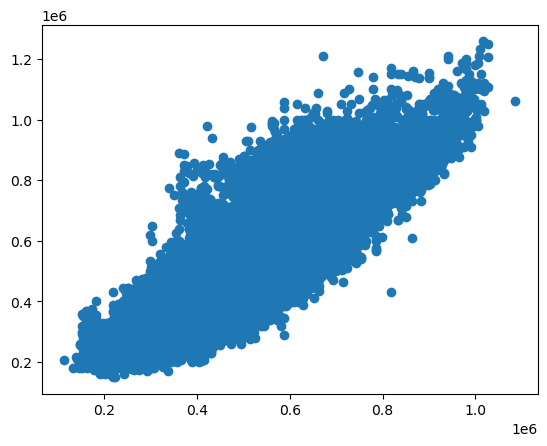

In [48]:
#Predicting y
ridge_y_pred = Ridge_pipeline.predict(X_train)
plt.scatter(ridge_y_pred,y_train);

##### R2 Score for Training set

In [49]:
#training
Ridge_pipeline.score(X_train,y_train)
print(f'R2 score(Training): {Ridge_pipeline.score(X_train,y_train)}')

#validation
Ridge_pipeline.score(X_val,y_val)
print(f'R2 score(Validation)): {Ridge_pipeline.score(X_val,y_val)}')

#cross validation
cross_val_score(Ridge_pipeline,X_train,y_train, cv=5).mean()
print(f'Cross Val score: {cross_val_score(Ridge_pipeline,X_train,y_train, cv=5).mean()}')

R2 score(Training): 0.7683308956546645
R2 score(Validation)): 0.7725372623496287
Cross Val score: 0.7682797850325468


##### RMSE and Median Resale Price

In [50]:
#predicting the validation set
ridge_y_pred_train = Ridge_pipeline.predict(X_train)

#R2 training and RMSE training set
ridge_y_pred_train = Ridge_pipeline.predict(X_train)
r2_score(y_train, ridge_y_pred_train), mean_squared_error(y_train, ridge_y_pred_train)**0.5
print(f'RMSE Test(Training) = {mean_squared_error(y_train, ridge_y_pred_train)**0.5}')

#Validate the prediction with R2 Test and RMSE Set
ridge_y_pred_val = Ridge_pipeline.predict(X_val)
r2_score(y_val, ridge_y_pred_val), mean_squared_error(y_val, ridge_y_pred_val)**0.5
print(f'RMSE Test(Validation) = {mean_squared_error(y_val, ridge_y_pred_val)**0.5}')

RMSE Test(Training) = 68958.9970363399
RMSE Test(Validation) = 68446.25449800504


### Lasso Regression

In [51]:
from sklearn.linear_model import Lasso, LassoCV
from sklearn import linear_model

In [52]:
clf = linear_model.Lasso(max_iter = 10000)

In [53]:
Lasso_steps=[
    ("ct", col_transformer),
    ('feat_sel', SelectKBest(k=30)),
    ("lesso_regression", clf)]

Lasso_pipeline = Pipeline(steps = Lasso_steps)

In [54]:
Lasso_pipeline.fit(X_train,y_train)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 90099942254659.78, tolerance: 262816504433.739
  model = cd_fast.sparse_enet_coordinate_descent(


Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('numerical', StandardScaler(),
                                                  ['lease_commence_date',
                                                   'tranc_year', 'tranc_month',
                                                   'lower', 'upper', 'mid',
                                                   'floor_area_sqft', 'hdb_age',
                                                   'max_floor_lvl',
                                                   'year_completed',
                                                   '1room_sold', '2room_sold',
                                                   '3room_sold', '4room_sold',
                                                   '5room_sold', 'exec_sold',
                                                   'multigen_sold',
                                                   'studio_apartment_sold',
                                                   '1room_rental',
 

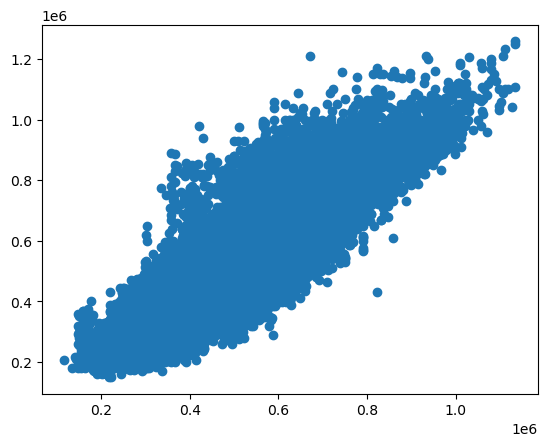

In [55]:
lasso_y_pred = Lasso_pipeline.predict(X_train)
plt.scatter(lasso_y_pred,y_train);

##### R2 Score for Training set

In [56]:
#training
Lasso_pipeline.score(X_train,y_train)
print(f'R2 score(Training): {Lasso_pipeline.score(X_train,y_train)}')

#validation
Lasso_pipeline.score(X_val,y_val)
print(f'R2 score(Validation)): {Lasso_pipeline.score(X_val,y_val)}')

#cross validation
#cross_val_score(Lasso_pipeline,X_train,y_train, cv=5).mean()
#print(f'Cross Val score: {cross_val_score(Lasso_pipeline,X_train,y_train, cv=5).mean()}')

R2 score(Training): 0.7695338427892024
R2 score(Validation)): 0.7737147322440567


##### RMSE and Median Resale Price

In [57]:
#predicting the validation set
Lass_y_pred_train = Lasso_pipeline.predict(X_train)

#R2 training and RMSE training set
Lass_y_pred_train = Lasso_pipeline.predict(X_train)
r2_score(y_train, Lass_y_pred_train), mean_squared_error(y_train, Lass_y_pred_train)**0.5
print(f'RMSE Test(Training) = {mean_squared_error(y_train, Lass_y_pred_train)**0.5}')

#Validate the prediction with R2 Test and RMSE Set
Lass_y_pred_val = Lasso_pipeline.predict(X_val)
r2_score(y_val, Lass_y_pred_val), mean_squared_error(y_val, Lass_y_pred_val)**0.5
print(f'RMSE Test(Validation) = {mean_squared_error(y_val, Lass_y_pred_val)**0.5}')

RMSE Test(Training) = 68779.72843299613
RMSE Test(Validation) = 68268.86725985706


##### Evaluation: RMSE

In [58]:


#linear regression
print("Linear Regression:")
print(f'R2 score(Validation)): {lr_pipeline.score(X_val,y_val)}')
print(f'RMSE Test(Training) = {mean_squared_error(y_train, lr_y_pred_train)**0.5}')
print(f'RMSE Test(Validation) = {mean_squared_error(y_val, ridge_y_pred_val)**0.5}')
print()

#ridge regression
print("Ridge Regression:")
print(f'R2 score(Validation)): {Ridge_pipeline.score(X_val,y_val)}')
print(f'RMSE Test(Training) = {mean_squared_error(y_train, ridge_y_pred_train)**0.5}')
print(f'RMSE Test(Validation) = {mean_squared_error(y_val, ridge_y_pred_val)**0.5}')
print()

#lasso regression
print("Lasso Regression:")
print(f'R2 score(Validation)): {Lasso_pipeline.score(X_val,y_val)}')
print(f'RMSE Test(Training) = {mean_squared_error(y_train, Lass_y_pred_train)**0.5}')
print(f'RMSE Test(Validation) = {mean_squared_error(y_val, Lass_y_pred_val)**0.5}')
print()

Linear Regression:
R2 score(Validation)): 0.773706623375942
RMSE Test(Training) = 68779.01661607466
RMSE Test(Validation) = 68446.25449800504

Ridge Regression:
R2 score(Validation)): 0.7725372623496287
RMSE Test(Training) = 68958.9970363399
RMSE Test(Validation) = 68446.25449800504

Lasso Regression:
R2 score(Validation)): 0.7737147322440567
RMSE Test(Training) = 68779.72843299613
RMSE Test(Validation) = 68268.86725985706



The average price prediction is at 68,000 SGD Based on the notes, the best model is usually the model with the lowest RMSE which turns out to be the Ridge model. The features we used was set at 30 features with alpha = 1. As the median is at 48,000 SGD , the difference between both prediction and median is not far which is a good indictor that it is not overfitting.

## Conclusion

Based on the lasso model using K-best feature selection of 30 to predict the price of HDB resale flat units was at 69K SGD with a R2 score of 77%. This is a slightly smaller number as compared to the other 2 models. 

Ridge model trades variance for bias. It is usually better than OLS when there are a large number of variables included because it has a penalty term to reduce overfitting and improve generalization to the testing set. However, based on the kaggle set of my submission at 90K points. It shows a slightly overfitting model which makes makes my model perform poorly. This can be due to certain factors in my modelling which means ther is room for improvement.

Comparsion between lasso and ridge, there are many factors to decide which model to use as Lasso can set some coefficients to zero, thus performing variable selection, while ridge regression cannot. Lasso tends to do well if there are a small number of significant parameters and the others are close to zero (ergo: when only a few predictors actually influence the response) while Ridge works well if there are many large parameters of about the same value (ergo: when most predictors impact the response) which in this case ridge is a better model.

## Recommendation

As this modelling is only at 1 iteration hence improvement could be made with multiple attempt to improve the model. Also, as there is a chance of overfitting which could be cause by the model complexity is high, so it learns the noise within the training data hence overfitting can be look into. 

## Test Dataset

I have import and clean the test dataset in conjunction when cleaning with the training dataset. Below are the steps to check if all cleaning is done.

In [59]:
df_test.head(10)

,yyyy-mmm,flat_type,storey_range,flat_model,lease_commence_date,tranc_year,tranc_month,lower,upper,mid,...,vacancy,pri_sch_affiliation,pri_sch_latitude,pri_sch_longitude,sec_sch_nearest_dist,sec_sch_name,cutoff_point,affiliation,sec_sch_latitude,sec_sch_longitude
0,2012-11,4 ROOM,07 TO 09,Simplified,1987,2012,11,7,9,8,...,92,0,1.433681,103.832924,156.322353,Ahmad Ibrahim Secondary School,218,0,1.436235,103.829987
1,2019-08,5 ROOM,04 TO 06,Premium Apartment,2008,2019,8,4,6,5,...,45,0,1.339244,103.698896,739.371688,Jurong West Secondary School,199,0,1.335256,103.702098
2,2013-10,3 ROOM,07 TO 09,New Generation,1980,2013,10,7,9,8,...,36,0,1.371893,103.851811,305.071191,Anderson Secondary School,245,0,1.374242,103.851430
3,2017-10,4 ROOM,01 TO 03,New Generation,1979,2017,10,1,3,2,...,54,0,1.434423,103.773698,433.454591,Woodlands Secondary School,188,0,1.439183,103.774499
4,2016-08,4 ROOM,16 TO 18,Model A,1985,2016,8,16,18,17,...,40,0,1.349195,103.741000,217.295361,Bukit Batok Secondary School,223,0,1.348351,103.740873
5,2016-10,3 ROOM,10 TO 12,Improved,1982,2016,10,10,12,11,...,74,0,1.323996,103.937745,634.114547,Temasek Junior College,249,1,1.318462,103.935598
6,2013-06,3 ROOM,01 TO 03,Model A,1988,2013,6,1,3,2,...,74,0,1.416280,103.838798,445.166164,Orchid Park Secondary School,208,0,1.414888,103.838335
7,2020-12,3 ROOM,13 TO 15,Model A,2016,2020,12,13,15,14,...,41,0,1.319969,103.923753,336.214634,Ping Yi Secondary School,189,0,1.327140,103.920836
8,2020-01,3 ROOM,13 TO 15,Model A,2015,2020,1,13,15,14,...,54,0,1.426998,103.844210,599.724794,Northland Secondary School,188,0,1.435740,103.840105
9,2013-11,3 ROOM,04 TO 06,Simplified,1986,2013,11,4,6,5,...,39,0,1.345245,103.756265,661.081611,Yusof Ishak Secondary School,188,0,1.342334,103.760013


In [60]:
df_test.isnull().sum().sum()

0

There is no null values as it has been cleaned earlier on. 

##### Fitting the test dataset into the model 

In [61]:
ridge_y_pred_val = Ridge_pipeline.predict(df_test)

In [62]:
df_test = pd.read_csv("./datasets/test.csv")
final_df = pd.DataFrame()
final_df['Id'] = df_test['id']
final_df['Predicted'] = ridge_y_pred_val
final_df.head(100)

/var/folders/rg/j9sphkcn70nbb5wrnyxnprk80000gn/T/ipykernel_58436/783844212.py:1: DtypeWarning: Columns (41) have mixed types. Specify dtype option on import or set low_memory=False.
  df_test = pd.read_csv("./datasets/test.csv")


,Id,Predicted
0,114982,330999.171563
1,95653,471887.886382
2,40303,376982.858224
3,109506,376159.230445
4,100149,484508.602248
...,...,...
95,62586,435126.109246
96,145868,416049.175802
97,15155,250499.111062
98,61290,305822.861211


In [63]:
final_df.to_csv('./datasets/final_df.csv', index=False)